Execution Instruction:

*   Environment: Colab
*   Data: Kaggle


In [ ]:
!rm -rf *.csv
!rm -rf suffled-images
!rm -rf uw-cs480-fall20.zip
!rm -rf sample_data
!rm -rf *.h5

In [ ]:
!pip install -q transformers
!pip install xgboost

In [ ]:
!ls

drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_PATH='/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "yukkiy"
os.environ['KAGGLE_KEY'] = "f57ccfa218c9719dd46d9401bb8bffc4"

import kaggle

kaggle.api.authenticate()
kaggle.api.competition_download_files("uw-cs480-fall20", path='.', quiet=False)

  0%|          | 0.00/85.6M [00:00<?, ?B/s]

100%|██████████| 85.6M/85.6M [00:02<00:00, 34.3MB/s]

In [ ]:
import time

import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dropout, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import regularizers

from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from transformers import RobertaConfig, TFRobertaModel, RobertaTokenizerFast

import xgboost as xgb
import matplotlib.pyplot as plt


In [ ]:
!unzip -q uw-cs480-fall20.zip -d .
%ls

drive/                 suffled-images/  train.csv
sample_submission.csv  test.csv         uw-cs480-fall20.zip


In [ ]:
INPUT_PATH = '/content/'
INPUT_IMAGE_PATH = '/content/suffled-images/shuffled-images/'

data_size = 21627
train_size = 19224
test_size = 2403

batch_size = 32
num_epochs = 50
image_shape = (80, 60, 3)

num_training_vgg = 5

predict_size = 21628

description_model_name = 'roberta-large'


In [ ]:
dataframe = pd.read_csv(INPUT_PATH + 'train.csv', header=0)
dataframe_predict = pd.read_csv(INPUT_PATH + 'test.csv', header=0)
data = dataframe.values.copy()
data_predict = dataframe_predict.values.copy()

data_image_id = data[:, 0]
data_category = data[:, 1]
data_feature = data[:, [2, 3, 4, 5]]
data_description = data[:, 6]

predict_image_id = data_predict[:, 0]
predict_feature = data_predict[:, [1, 2, 3, 4]]
predict_description = data_predict[:, 5]

In [ ]:
shuffle_indices = np.arange(data_size)
np.random.shuffle(shuffle_indices)

In [ ]:
# image processing

data_image = np.zeros(shape=(data_size, image_shape[0], image_shape[1], image_shape[2]))

for i in range(data_size):
    id = data_image_id[i]
    img = load_img(INPUT_IMAGE_PATH + str(id) +'.jpg')
    img = img_to_array(img)
    img = preprocess_input(img)
    data_image[i] = img

data_image = data_image[shuffle_indices]

train_image = data_image[: train_size]
test_image = data_image[train_size :]


# # This will do preprocessing and realtime data augmentation:
# image_datagen = ImageDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     zca_epsilon=1e-06,  # epsilon for ZCA whitening
#     rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#     # randomly shift images horizontally (fraction of total width)
#     width_shift_range=0.1,
#     # randomly shift images vertically (fraction of total height)
#     height_shift_range=0.1,
#     shear_range=0.,  # set range for random shear
#     zoom_range=0.,  # set range for random zoom
#     channel_shift_range=0.,  # set range for random channel shifts
#     # set mode for filling points outside the input boundaries
#     fill_mode='nearest',
#     cval=0.,  # value used for fill_mode = "constant"
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False,  # randomly flip images
#     # set rescaling factor (applied before any other transformation)
#     rescale=None,
#     # set function that will be applied on each input
#     preprocessing_function=None,
#     # image data format, either "channels_first" or "channels_last"
#     data_format=None,
#     # fraction of images reserved for validation (strictly between 0 and 1)
#     validation_split=0.0)

# # Compute quantities required for feature-wise normalization
# # (std, mean, and principal components if ZCA whitening is applied).
# image_datagen.fit(train_image)


predict_image = np.zeros(shape=(predict_size, image_shape[0], image_shape[1], image_shape[2]))

for i in range(predict_size):
    id = predict_image_id[i]
    img = load_img(INPUT_IMAGE_PATH + str(id) +'.jpg')
    img = img_to_array(img)
    img = preprocess_input(img)
    predict_image[i] = img

In [ ]:
# description processing

data_description_feature = np.empty(shape=data_description.shape, dtype=data_description.dtype)

def string_combine(str1, str2, str3, str4, str5):
    return str1 + ' ' + str2 + ' ' + str3 + ' ' + str4 + ' ' + str5

for i in range(data_size):
    data_description_feature[i] = string_combine(data_description[i], 
                                                 data_feature[i][0], 
                                                 data_feature[i][1], 
                                                 data_feature[i][2], 
                                                 data_feature[i][3])

data_description_feature = data_description_feature[shuffle_indices]
train_description_feature = data_description_feature[: train_size]
test_description_feature = data_description_feature[train_size :]


predict_description_feature = np.empty(shape=predict_description.shape, dtype=predict_description.dtype)

for i in range(predict_size):
    predict_description_feature[i] = string_combine(predict_description[i], 
                                                    predict_feature[i][0], 
                                                    predict_feature[i][1], 
                                                    predict_feature[i][2], 
                                                    predict_feature[i][3])



In [ ]:
description_maxlength = 1

# max length of tokens
for description in np.concatenate((data_description_feature, predict_description_feature)):
    description_maxlength = max(description_maxlength, len(description))

# load transformers config and set output_hidden_states to False
roberta_config = RobertaConfig.from_pretrained(description_model_name)
roberta_config.output_hidden_states = False

#load RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizerFast.from_pretrained(pretrained_model_name_or_path = description_model_name, config = roberta_config)


train_description_feature_token = roberta_tokenizer(
    text=train_description_feature.tolist(),
    add_special_tokens=True,
    max_length=description_maxlength,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = 1)

test_description_feature_token = roberta_tokenizer(
    text=test_description_feature.tolist(),
    add_special_tokens=True,
    max_length=description_maxlength,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = 1)

predict_description_feature_token = roberta_tokenizer(
    text=predict_description_feature.tolist(),
    add_special_tokens=True,
    max_length=description_maxlength,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = 1)


In [ ]:
# category processing

categories = np.unique(data_category)
num_category = categories.shape[0]

code_to_categ = {}
categ_to_code = {}

for code in range(num_category):
    code_to_categ[code] = categories[code]
    categ_to_code[categories[code]] = code

data_category_code = np.zeros(shape=data_category.shape)

for i in range(data_size):
    data_category_code[i] = categ_to_code[data_category[i]]

data_category_code_categorical = to_categorical(data_category_code, num_category)


data_category_code_categorical = data_category_code_categorical[shuffle_indices]
train_category_code_categorical = data_category_code_categorical[: train_size]
test_category_code_categorical = data_category_code_categorical[train_size :]


In [ ]:
# define image model

vgg19 = VGG19(include_top=False, weights="imagenet", input_shape=image_shape, pooling='max', classes=num_category)
for layer in vgg19.layers[: -1 * num_training_vgg]:
    layer.trainable = False

image_layers_output = vgg19.output
image_layers_output = Dense(1024, activation='relu')(image_layers_output)


In [ ]:
# define description model

token_maxlength = max(train_description_feature_token['input_ids'].shape[1], test_description_feature_token['input_ids'].shape[1])
token_maxlength = max(token_maxlength, predict_description_feature_token['input_ids'].shape[1])

# load the transformres RoBERTa model
transformer_model = TFRobertaModel.from_pretrained(description_model_name, config = roberta_config)

# Load the MainLayer
roberta = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(token_maxlength,), name='input_ids', dtype='int32')
# attention_mask = Input(shape=(token_maxlength), name='attention_mask', dtype='int32')
description_inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
description_layers_output = roberta(description_inputs)[1]
roberta_dropout = Dropout(roberta_config.hidden_dropout_prob, name="pooled_output")
description_layers_output = roberta_dropout(description_layers_output, training=False)


Some layers from the model checkpoint at roberta-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
# define ensemble model

ensemble = Concatenate(axis=1)([image_layers_output, description_layers_output])
ensemble = Dropout(0.1)(ensemble)
ensemble = Dense(512, activation='relu')(ensemble)
ensemble = Dropout(0.2)(ensemble)
ensemble_predictions = Dense(num_category, activation='softmax')(ensemble)

ensemble_model = Model(inputs=[vgg19.input, description_inputs], outputs=[ensemble_predictions])



In [ ]:
opt_ensemble = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)

ensemble_model.compile(loss='categorical_crossentropy',
              optimizer=opt_ensemble,
              metrics=['accuracy'])

print(ensemble_model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 60, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 80, 60, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 80, 60, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 40, 30, 64)   0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [ ]:

save_best_model_ensemble = ModelCheckpoint('best_model_ensemble.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        print(self.times[-1], ' seconds')

time_callback = TimeHistory()


history_ensemble = ensemble_model.fit([train_image, train_description_feature_token['input_ids']], train_category_code_categorical, 
                                            batch_size=batch_size,
                                            epochs=num_epochs, 
                                            validation_data=([test_image, test_description_feature_token['input_ids']], test_category_code_categorical),
                                            shuffle=True,
                                            callbacks=[save_best_model_ensemble, time_callback])

Epoch 1/50
601/601 [==============================] - ETA: 0s - loss: 1.3744 - accuracy: 0.6788WARNING:tensorflow:Model was constructed with shape (None, 49) for input Tensor("input_ids:0", shape=(None, 49), dtype=int32), but it was called on an input with incompatible shape (None, 41).

Epoch 00001: val_accuracy improved from -inf to 0.92593, saving model to best_model_ensemble.h5
399.23959136009216  seconds
601/601 [==============================] - 370s 615ms/step - loss: 1.3744 - accuracy: 0.6788 - val_loss: 0.3392 - val_accuracy: 0.9259
Epoch 2/50
601/601 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.9297
Epoch 00002: val_accuracy improved from 0.92593 to 0.94632, saving model to best_model_ensemble.h5
365.76877450942993  seconds
601/601 [==============================] - 365s 608ms/step - loss: 0.2895 - accuracy: 0.9297 - val_loss: 0.1869 - val_accuracy: 0.9463
Epoch 3/50
601/601 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.955

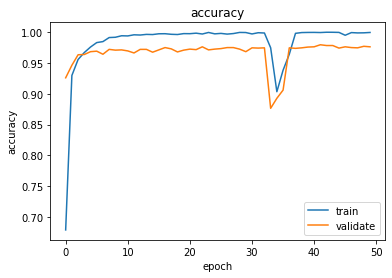

In [ ]:
plt.plot(history_ensemble.history['accuracy'], label='train')
plt.plot(history_ensemble.history['val_accuracy'], label='validate')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
saved_model = load_model('best_model_ensemble.h5')
predicted_category_ensemble = saved_model.predict([predict_image, predict_description_feature_token['input_ids']], batch_size=batch_size, verbose=1)
predicted_category_code = np.argmax(predicted_category_ensemble, axis=-1)

676/676 [==============================] - 150s 222ms/step


In [ ]:
predicted_category = np.empty(shape=predict_size, dtype=data_category.dtype)

for i in range(predict_size):
    predicted_category[i] = code_to_categ[predicted_category_code[i]]

submission = np.concatenate((predict_image_id.reshape((predict_size, 1)), predicted_category.reshape((predict_size, 1))), axis=1)
np.savetxt(DRIVE_PATH + 'submission_ensemble.csv', submission, fmt='%d,%s', header='id,category', comments='')

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
